In [1]:
import pinecone
from pinecone import Pinecone, ServerlessSpec
import os
from dotenv import load_dotenv
import base64

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pinecone/data/index.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Creating a Pinecone Index

In [52]:
load_dotenv() 

True

In [4]:
pc=Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name=os.getenv("INDEX_NAME")
index_list = [index.name for index in pc.list_indexes()]

spec=ServerlessSpec(
    cloud="aws",
    region=os.getenv("PINECONE_ENVIRONMENT")
)

In [5]:
region=os.getenv("PINECONE_ENVIRONMENT")
region

'us-east-1'

In [ ]:
if index_name not in index_list:
    pc.create_index(
        name = index_name,
        dimension = 1024,
        metric = "cosine",
        spec = spec
    )
else: 
    index = pc.Index(index_name)
    dimension = index.describe_index_stats()["dimension"]
    if dimension != 1024:
        pc.delete_index(index_name)
        pc.create_index(
            name = index_name,
            dimension = 1024,
            metric = "cosine",
            spec = spec
        )

In [149]:
index = pc.Index(index_name)

# PDF Information Extraction

In [9]:
from mistralai import Mistral
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

In [10]:
api_key = os.environ.get("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

In [15]:

def ocr_response(file_path: str) -> OCRResponse:
    '''
    This function takes a file path and returns the OCR response.
    '''
    uploaded_pdf = client.files.upload(
        file={
            "file_name": os.path.basename(file_path),
            "content": open(file_path, "rb"),
        },
    purpose="ocr"
    )  

    # Getting the signed URL for the uploaded PDF
    signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)

    # To extract text from the uploaded PDF using OCR
    ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": signed_url.url,
      },
      include_image_base64=True
    )

    # response_dict = json.loads(ocr_response.model_dump_json())
    return ocr_response

In [16]:
def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.

    Args:
        markdown_str: Markdown text containing image placeholders
        images_dict: Dictionary mapping image IDs to base64 strings

    Returns:
        Markdown text with images replaced by base64 data
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def get_combined_markdown(ocr_response: dict) -> str:
    """
    Combine OCR text and images into a single markdown document.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Combined markdown string with embedded images
    """
    markdowns: list[str] = []
    # Extract images from page
    for page in ocr_response.pages:
        image_data = {}
        for img in page.images:
            image_data[img.id] = img.image_base64
        # Replace image placeholders with actual images
        markdowns.append(replace_images_in_markdown(page.markdown, image_data))

    return "\n\n".join(markdowns)

In [23]:
dir_name = 'pdf_collection'
syllabus_path = os.path.join(dir_name, os.listdir(dir_name)[3])
complex_graph_path = os.path.join(dir_name, os.listdir(dir_name)[2])
syllabus_path, complex_graph_path

('pdf_collection/syllabus.pdf', 'pdf_collection/complex_graph.pdf')

In [17]:
syllabus_ocr = ocr_response(syllabus_path)

In [22]:
syllabus_ocr_images = get_combined_markdown(syllabus_ocr)
syllabus_ocr_images

"The information contained on this page is designed to give students a representative example of material covered in the course. Any information related to course assignments, dates, or course materials is illustrative only.\n\n# (2) NYU <br> TANDON SCHOOL OF ENGINEERING \n\n## Course Syllabus\n\nComputer Science and Engineering\nPrinciples of Database Systems\n\n## Course Information\n\n## Course Prerequisites\n\nGraduate student status.\n\n## Course Description\n\nThis course broadly introduces database systems, including the relational data model, query languages, database design, index and file structures, query processing and optimization, concurrency and recovery, transaction management and database design. Students acquire hands-on experience in working with database systems and in building web-accessible database applications.\n\n## Course Objectives\n\nThis course will provide students with the opportunity to:\n\n- Apply queries in relational algebra to retrieve data.\n- Apply

In [28]:
display(Markdown(syllabus_ocr_images))

The information contained on this page is designed to give students a representative example of material covered in the course. Any information related to course assignments, dates, or course materials is illustrative only.

# (2) NYU <br> TANDON SCHOOL OF ENGINEERING 

## Course Syllabus

Computer Science and Engineering
Principles of Database Systems

## Course Information

## Course Prerequisites

Graduate student status.

## Course Description

This course broadly introduces database systems, including the relational data model, query languages, database design, index and file structures, query processing and optimization, concurrency and recovery, transaction management and database design. Students acquire hands-on experience in working with database systems and in building web-accessible database applications.

## Course Objectives

This course will provide students with the opportunity to:

- Apply queries in relational algebra to retrieve data.
- Apply queries in SQL to create, read, update and delete data in a database.
- Apply the concepts of entity integrity constraint and referential integrity constraint (including definition of the concept of a foreign key).
- Describe the normal forms (1NF, 2NF, 3NF, BCNF, and 4NF) of a relation.
- Apply normalization to a relation to create a set of BCNF relations and denormalize a relational schema.

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

- Describe functional dependency between two or more attributes that are a subset of a relation.
- Understand multi-valued dependency and identify examples in relational schemas.
- Sketch conceptual data models (including ER) to describe a database structure.
- Apply SQL to create a relational database schema based on conceptual and relational models.
- Apply stored procedures, functions, and triggers using a commercial relational DBMS.
- Describe concurrency control and how it is affected by isolation levels in the database.
- Analyze Current Research in Database Systems.


## Course Structure

This course is conducted entirely online, which means you do not have to be on campus to complete any portion of it. You will participate in the course using NYU Classes located at https://newclasses.nyu.edu Your final grade will be computed as a combination of the components shown below.

- Quizzes: 30\%
- Labs: $40 \%$
- Project: $30 \%$


## Weekly Structure

Week 1: Introduction to the Relational Model

- Introduce class and overview of course topics.

Weeks 2-4: SQL Language

# NYU TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

- Introduction to SQL
- Intermediate SQL
- Advanced SQL

Week 5: Formal Relational Query Languages

- Relational Algebra
- Tuple Relational Calculus
- Domain Relational Calculus

Week 6: Database Design: The Entity-Relationship Approach

- ER Design
- Reduction to Relational Model

Week 7: Relational Database Design

- Functional Dependency
- Multivalued Dependency
- Normal Forms.

Week 8: Application Design

- Web Architectures
- Application Security

Week 9: Storage and File Structure

- Physical Storage
- Record Organization

Week 10: Indexing and Hashing

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

- Ordered Indices
- Hashed Indices
- Bitmap Indices

Weeks 11-12: Query Processing \& Optimization

- Query Processing
- Query Optimization

Week 13: Transactions \& Concurrency Control

- ACID Properties
- Transaction Management

Week 14: Recovery System \& Database System Architectures

- Locks
- Deadlocks
- Snapshot Isolation

Week 15: Student Presentations

- Presentations and reviews


## Learning Time Rubric

Please modify the below table to represent the breakdown of learning time in each week of your course.

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

| Learning <br> Time <br> Element | Asynchronous* / <br> Synchronous** | Time on <br> Task for <br> Students <br> (weekly) | Notes |
| :--: | :--: | :--: | :-- |
| Reading <br> Assignments <br> / Recorded <br> Lecture | Asynchronous | 2.5 hours | Video format. <br> Expect quizzes <br> throughout the <br> module or <br> weekly chapter <br> readings |
| Weekly <br> Discussion <br> Board \& Peer <br> Review | Asynchronous | 1.5 hours | Students are <br> expected to post <br> responses to <br> weekly topic <br> questions. See <br> Interaction <br> Policy. |
| Assessment <br> (Labs and <br> Programming <br> assignments) | Asynchronous | 2 hours | Students submit <br> their assignment <br> by [the end of <br> the week] |
| Reading <br> Assignment | Asynchronous | 2 hours | Reading <br> assigned <br> textbook <br> chapters and <br> journal articles. |
| Live webinars | Synchronous | 2 hours | Group <br> discussion in <br> class, live, <br> overly weekly <br> chapter |

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

## Course Communication

## Interaction Policy

Please follow the interaction guidelines stated below for this course.

- I will be holding online virtual classroom sessions every week. This virtual classroom will be held via NYU Classes on Thursdays from 8am to 9am.
- The course will involve regular discussions via the Discussion Forums within NYU Classes and students are encouraged to participate.
- If you have a technical or course content related question, please send me an email. If I think that your question can benefit the class, I might post it on the discussion forum.
- If you have a question related to grading, please send an email to the TA and cc on the email thread. The TA will be responsible for examining your answers and providing a grade as per my guidelines.
- If any other questions need to be answered that are not addressed via email or the live classroom, I can hold virtual office hours on an appointment basis.


## Announcements

Announcements will be posted on NYU Classes on a regular basis. You can locate all class announcements under the Announcements tab of our class. Be sure to check the class announcements regularly as they will contain important information about class assignments and other class matters.

## Email

You are encouraged to post your questions about the course in the Forums discussions on NYU Classes. This is an open forum in which you and your classmates are encouraged to answer each other's questions. But, if you need to contact me directly, please email me. All

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System
homework, labs or programming assignments related questions must be researched first on own time, then posted on forums, then discussed with TAs during weekly reviews, and then can be forwarded to me. Typically, you can expect a response within 48 hours.

## Readings

Avi Silberschatz, Henry F. Korth,S. Sudarshan, Database System Concepts, Sixth Edition, McGraw Hill

You can access NYU's central library here: http://library.nyu.edu/
You can access NYU Tandon's Bern Dibner Library here:
http://library.poly.edu/

RECOMMENDED READINGS are online journal articles provided in each lecture You can access NYU's central library here: http://library.nyu.edu/

You can access NYU Tandon's Bern Dibner Library here:
http://library.poly.edu/

## Assignments and Exams

## Exams Administered and Proctored Online

Exams in this course are administered through NYU Classes. You are required to arrange an online proctor for your exams via ProctorU. More information on ProctorU and scheduling proctoring sessions can be found on Tandon Online's website.

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System

## Exams Administered On Paper and Proctored Remotely

Exams in this course are administered via paper and pencil. If you are not able to attend an exam session on-campus, you are required to secure in-person proctoring arrangements near your location. Tandon Online's website.

## University Policies

## Moses Center Statement of Disability

Academic accommodations are available for students with disabilities. Please contact the Moses Center for Students with Disabilities (212-998-4980 or mosescsd@nyu.edu) for further information. Students who are requesting academic accommodations are advised to reach out to the Moses Center as early as possible in the semester for assistance.

## NYU Tandon School of Engineering Policies and Procedures on Academic Misconduct ${ }^{1}$

A. Introduction: The School of Engineering encourages academic excellence in an environment that promotes honesty, integrity, and fairness, and students at the School of Engineering are expected to exhibit those qualities in their academic work. It is through the process of submitting their own work and receiving honest feedback on that work that students may progress academically. Any act of academic dishonesty is seen as an attack upon the School and will not be tolerated. Furthermore, those who breach the School's rules on academic integrity will be sanctioned under this Policy. Students are responsible for familiarizing themselves with the School's Policy on Academic Misconduct.
B. Definition: Academic dishonesty may include misrepresentation, deception, dishonesty, or any act of falsification committed by a student to influence a grade or other academic evaluation. Academic dishonesty also includes intentionally damaging the academic work of others or assisting other students in acts of dishonesty. Common

[^0]
[^0]:    ${ }^{1}$ Excerpted from the Tandon School of Engineering Student Code of Conduct

# NYU <br> TANDON SCHOOL OF ENGINEERING 

Course Syllabus - CS GY 6083 Principles of Database System
examples of academically dishonest behavior include, but are not limited to, the following:
a. Cheating: intentionally using or attempting to use unauthorized notes, books, electronic media, or electronic communications in an exam; talking with fellow students or looking at another person's work during an exam; submitting work prepared in advance for an in-class examination; having someone take an exam for you or taking an exam for someone else; violating other rules governing the administration of examinations.
b. Fabrication: including but not limited to, falsifying experimental data and/or citations.
c. Plagiarism: intentionally or knowingly representing the words or ideas of another as one's own in any academic exercise; failure to attribute direct quotations, paraphrases, or borrowed facts or information.
d. Unauthorized collaboration: working together on work that was meant to be done individually.
e. Duplicating work: presenting for grading the same work for more than one project or in more than one class, unless express and prior permission has been received from the course instructor(s) or research adviser involved.
f. Forgery: altering any academic document, including, but not limited to, academic records, admissions materials, or medical excuses.

In [25]:
complex_graph_ocr = ocr_response(complex_graph_path)

'\n\nFigure 2: Pixtral Vision Encoder. Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers.\n\n# 2 Architectural details \n\nPixtral 12B is based on the transformer architecture [22], and consists of a multimodal decoder to perform highlevel reasoning, and a vision encoder to allow the model to ingest images. The main parameters of the model are summarized in Table 1.\n\n### 2.1 Multimodal Decoder\n\nPixtral 12B is built on top of Mistral Nemo 12B [15], a 12-billion parameter decoder-only language model that achieves strong performance across a range of knowledge and reasoning tasks.\n\n| Parameters | Decoder | Encoder |\n| :-- | --: | --:
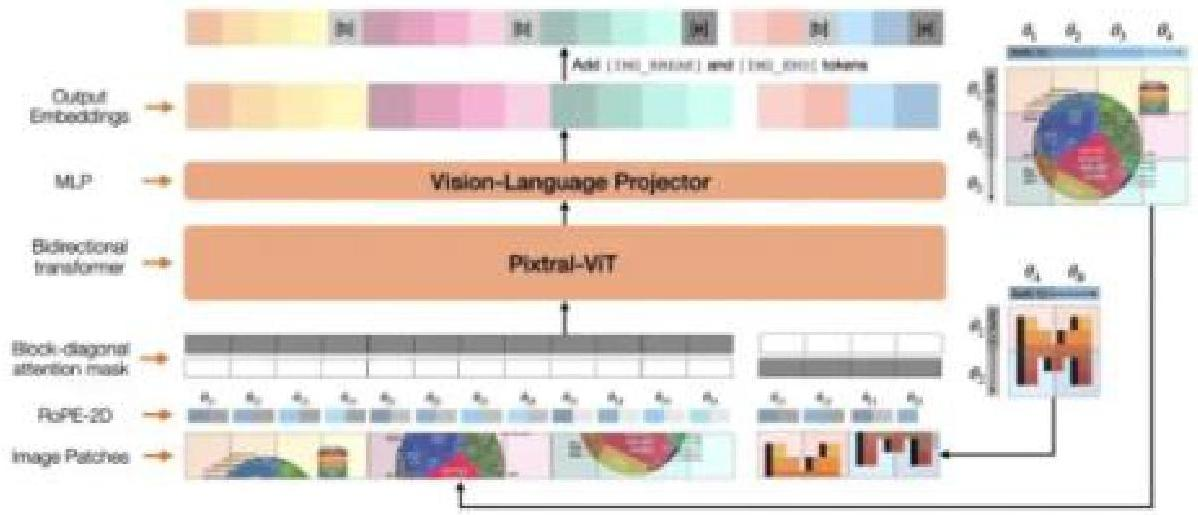

In [26]:
complex_graph_ocr_images = get_combined_markdown(complex_graph_ocr)
complex_graph_ocr_images

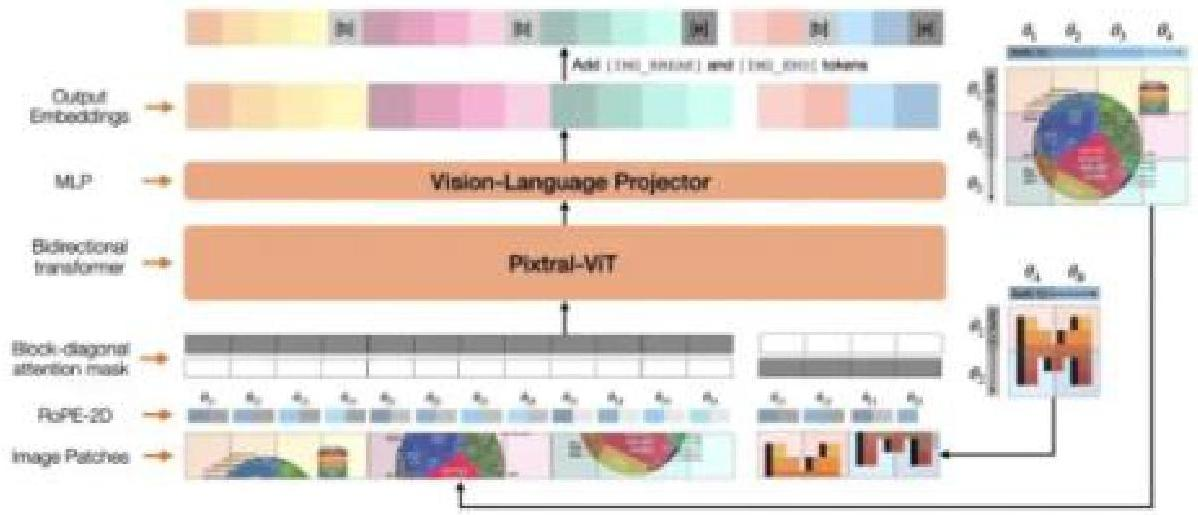

Figure 2: Pixtral Vision Encoder. Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers.

# 2 Architectural details 

Pixtral 12B is based on the transformer architecture [22], and consists of a multimodal decoder to perform highlevel reasoning, and a vision encoder to allow the model to ingest images. The main parameters of the model are summarized in Table 1.

### 2.1 Multimodal Decoder

Pixtral 12B is built on top of Mistral Nemo 12B [15], a 12-billion parameter decoder-only language model that achieves strong performance across a range of knowledge and reasoning tasks.

| Parameters | Decoder | Encoder |
| :-- | --: | --: |
| dim | 5120 | 1024 |
| n_layers | 40 | 24 |
| head_dim | 128 | 64 |
| hidden_dim | 14336 | 4096 |
| n_heads | 32 | 16 |
| n_kv_heads | 8 | 16 |
| context_1en | 131072 | 4096 |
| vocab_size | 131072 | - |
| patch_size | - | 16 |

Table 1: Decoder and encoder parameters.

### 2.2 Vision Encoder

In order for Pixtral 12B to ingest images, we train a new vision encoder from scratch, named PixtralViT. Here, our goal is to instantiate a simple architecture which is capable of processing images across a wide range of resolutions and aspect ratios. To do this, we build a 400 million parameter vision transformer [5] (see Table 1) and make four key changes over the standard architectures [17]:

Break tokens: In order to assist the model in distinguishing between images with the same number of patches (same area) but different aspect ratios, we include [IMAGE BREAK] tokens between image rows [2]. We further include an [IMAGE END] token at the end of an image sequence.
Gating in FFN: Instead of standard feedforward layer in the attention block, we use gating in the hidden layer [19].
Sequence packing: In order to efficiently process images within a single batch, we flatten the images along the sequence dimension and concatenate them [3]. We construct a block-diagonal mask to ensure no attention leakage between patches from different images.
RoPE-2D: We replace traditional learned and absolute position embeddings for image patches with relative, rotary position encodings [11, 20] in the self-attention layers. While learned position embeddings must be interpolated to deal with new image sizes (often at the cost of performance), relative position encodings lend themselves naturally to variable image sizes.

In [30]:
display(Markdown(complex_graph_ocr_images))

## Chunking

Chunk size: ideal at 1024 https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5

In [31]:
from langchain.text_splitter import MarkdownTextSplitter

In [41]:
def get_markdown_text_only(ocr_response: dict) -> str:
    """
    Extract text content from OCR response, skipping image data.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Text content from OCR response, excluding image data
    """
    markdowns: list[str] = []
    for page in ocr_response.pages:
        markdowns.append(page.markdown)
    return "\n\n".join(markdowns)

In [109]:
def get_markdown_image_only(ocr_response: dict) -> list[str]:
    """
    Extract image data from OCR response, skipping text content.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Markdown string containing only image data
    """
    markdowns: list[str] = []
    for page in ocr_response.pages:
        image_data = {}
        for img in page.images:
            image_data[img.id] = img.image_base64
            markdowns.append(f"{img.image_base64}")

    return markdowns


In [70]:
syllabus_text_only  = get_markdown_text_only(syllabus_ocr)

markdown_splitter = MarkdownTextSplitter(chunk_size=1024, chunk_overlap=512)
syllabus_text_only_list = markdown_splitter.create_documents([syllabus_text_only])
syllabus_text_only_list

20


[Document(metadata={}, page_content='The information contained on this page is designed to give students a representative example of material covered in the course. Any information related to course assignments, dates, or course materials is illustrative only.\n\n# (2) NYU <br> TANDON SCHOOL OF ENGINEERING \n\n## Course Syllabus\n\nComputer Science and Engineering\nPrinciples of Database Systems\n\n## Course Information\n\n## Course Prerequisites\n\nGraduate student status.\n\n## Course Description\n\nThis course broadly introduces database systems, including the relational data model, query languages, database design, index and file structures, query processing and optimization, concurrency and recovery, transaction management and database design. Students acquire hands-on experience in working with database systems and in building web-accessible database applications.\n\n## Course Objectives\n\nThis course will provide students with the opportunity to:'),
 Document(metadata={}, page_

In [110]:
syllabus_image_only_list= get_markdown_image_only(syllabus_ocr)
syllabus_image_only_list

[]

In [60]:
complex_graph_text_only = get_markdown_text_only(complex_graph_ocr)

markdown_splitter = MarkdownTextSplitter(chunk_size=1024, chunk_overlap=512)
complex_graph_text_only_list = markdown_splitter.create_documents([complex_graph_text_only])
complex_graph_text_only_list

[Document(metadata={}, page_content='![img-0.jpeg](img-0.jpeg)\n\nFigure 2: Pixtral Vision Encoder. Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers.\n\n# 2 Architectural details \n\nPixtral 12B is based on the transformer architecture [22], and consists of a multimodal decoder to perform highlevel reasoning, and a vision encoder to allow the model to ingest images. The main parameters of the model are summarized in Table 1.\n\n### 2.1 Multimodal Decoder\n\nPixtral 12B is built on top of Mistral Nemo 12B [15], a 12-billion parameter decoder-only language model that achieves strong performance across a range of knowledge and reasoning ta

['']
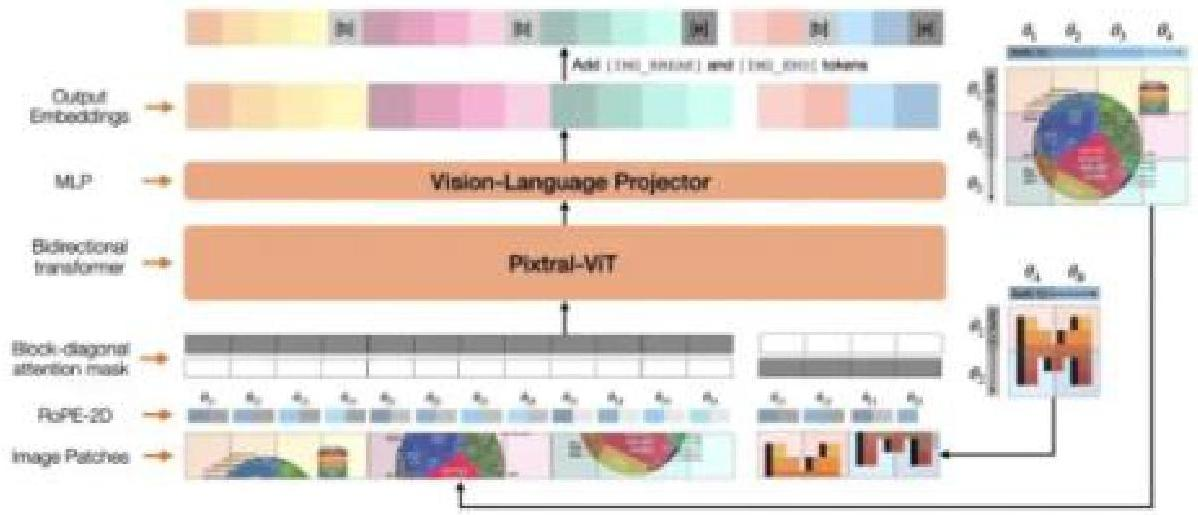

In [111]:
complex_graph_image_only_list = get_markdown_image_only(complex_graph_ocr)
complex_graph_image_only_list

## Embedding

In [51]:
import cohere

In [56]:
co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))

In [83]:
def cohere_text_embed(documents: list[str]) -> list[float]:
    if not documents:
        return None
    text_to_embed = [doc.page_content for doc in documents]

    return co.embed(
        texts=text_to_embed,
        model="embed-english-v3.0",
        input_type="search_document",
        embedding_types=["float"],
    )

In [125]:
def cohere_image_embed(documents: list[str]) -> list[float]:
    if not documents:
        return None
    image_to_embed = [doc for doc in documents]

    return co.embed(
        images=image_to_embed,
        model="embed-english-v3.0",
        input_type="image",
        embedding_types=["float"],
    )

In [103]:
syllabus_text_embeddings = cohere_text_embed(syllabus_text_only_list)
syllabus_text_embeddings.embeddings.float_

[[0.013977051,
  -0.0030345917,
  -0.015220642,
  -0.04763794,
  -0.005832672,
  -0.01637268,
  -0.025314331,
  0.009086609,
  0.028396606,
  0.053833008,
  -0.029663086,
  -0.005935669,
  0.016662598,
  -0.008796692,
  -0.050567627,
  -0.015182495,
  0.07293701,
  -0.023925781,
  0.047180176,
  0.021713257,
  -0.023468018,
  0.06317139,
  0.033233643,
  0.020706177,
  0.02394104,
  0.028915405,
  0.0027332306,
  0.0064582825,
  0.001373291,
  -0.0013551712,
  0.024002075,
  -0.029464722,
  0.036224365,
  -0.030563354,
  0.020523071,
  0.017456055,
  -0.014083862,
  -0.007858276,
  -0.0054130554,
  0.007247925,
  0.0105896,
  0.0069618225,
  0.045135498,
  0.010955811,
  -0.01890564,
  0.008979797,
  -0.004676819,
  -0.016281128,
  -0.0016040802,
  -0.04473877,
  -0.012557983,
  0.046417236,
  0.018173218,
  -0.007888794,
  0.0056037903,
  0.018051147,
  -0.007843018,
  -0.053527832,
  0.025344849,
  0.037231445,
  -0.01689148,
  -0.03326416,
  0.01914978,
  -0.04901123,
  -0.00944519,

In [101]:
syllabus_image_embeddings = cohere_image_embed(syllabus_image_only_list)
syllabus_image_embeddings

[]

In [121]:
complex_graph_text_embeddings = cohere_text_embed(complex_graph_text_only_list)
complex_graph_text_embeddings

EmbedByTypeResponse(id='786648bf-52a7-44ea-b89b-fe2af3997da5', embeddings=EmbedByTypeResponseEmbeddings(float_=[[-0.06878662, -0.017410278, -0.0037727356, -0.014877319, -0.053833008, 0.03894043, -0.08660889, 0.0052604675, 0.047729492, 0.01979065, -0.03414917, -0.041656494, 0.033843994, -0.0021438599, -0.028793335, -0.011421204, 0.042633057, -0.012329102, 0.042388916, 0.018081665, 0.007675171, 0.05203247, 0.020187378, 0.026290894, -0.011169434, 0.03060913, -0.061157227, -0.0029945374, -0.029434204, -0.0069999695, -0.017623901, 0.03894043, 0.015304565, -0.0058631897, 0.00422287, -0.0068511963, 0.0017576218, -0.0061187744, -0.0014276505, 0.006061554, 0.012069702, -0.002544403, 0.09509277, -0.06188965, 0.03552246, 0.01727295, 0.007949829, -0.045074463, -0.018615723, 0.03012085, 0.016677856, 0.005092621, 0.016464233, 0.0034694672, -0.0002784729, -0.013366699, -0.022399902, -0.031829834, 0.023529053, 0.0569458, 0.021713257, -0.0007405281, -0.009429932, -0.026397705, -0.0034484863, 0.01220703

In [126]:
complex_graph_image_embeddings = cohere_image_embed(complex_graph_image_only_list)
complex_graph_image_embeddings.embeddings.float_

[[0.022735596,
  -0.028961182,
  -0.009002686,
  -0.07183838,
  -0.03640747,
  -0.0018405914,
  -0.04348755,
  -0.0023880005,
  0.023208618,
  0.04446411,
  -0.031311035,
  0.001455307,
  -0.030914307,
  -0.029891968,
  -0.023529053,
  -0.053009033,
  0.062469482,
  -0.009712219,
  0.04272461,
  0.007972717,
  0.013381958,
  0.041046143,
  0.014099121,
  0.011512756,
  0.01486969,
  -0.015556335,
  -0.061798096,
  0.0038394928,
  -0.03164673,
  -0.004173279,
  -0.0078125,
  0.046844482,
  0.050720215,
  -0.022140503,
  0.010726929,
  0.022644043,
  -0.017227173,
  -0.0046157837,
  0.0087890625,
  0.014099121,
  -0.024627686,
  0.007835388,
  0.053253174,
  -0.06854248,
  -0.028915405,
  0.042907715,
  -0.06585693,
  -0.06213379,
  0.029266357,
  0.06402588,
  -0.0090408325,
  0.0112838745,
  -0.022613525,
  0.0670166,
  -0.023757935,
  -0.008377075,
  -0.03616333,
  -0.012031555,
  0.02909851,
  0.020828247,
  -0.008346558,
  0.044647217,
  0.019332886,
  -0.013748169,
  -0.00010728836

## Upload Embeddings to Pinecone and Metadata Creation

In [156]:
import os
import base64
# from google.colab import drive
from datetime import datetime
import io
from PIL import Image

ModuleNotFoundError: No module named 'google.colab'

In [157]:
!pip install google.colab

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab


In [127]:
def pinecone_upsert(index, namespace, embeddings, metadata):
    '''
    Upsert embeddings and metadata into Pinecone
    '''
    if not embeddings:
        return
    
    # getting the id for entire embedding - will modify this for each chunk
    id = embeddings.id

    zip_embeddings = zip(embeddings.embeddings.float_, metadata)

    for i, (chunk_embedding, chunk_metadata) in enumerate(zip_embeddings):
        chunk_id = f"{id}_{i}"
        if index.fetch([chunk_id])['vectors']:
            print(f"ID {chunk_id} already exists in the database. Skipping upsert.")
            continue
        else:
            index.upsert(
                vectors=[{
                    'id': chunk_id,
                    'values': chunk_embedding,
                    'metadata': chunk_metadata
                }],
                namespace=namespace
            )
            print(f"Upserted {chunk_id} to Pinecone")
    return None

In [142]:
def create_text_metadata(documents: list[str]) -> dict:
    '''
    Create metadata for the embeddings
    '''
    metadata = []
    for i, doc in enumerate(documents):
        metadata.append({
            f"chunk_{i}": doc.page_content,
            "type": "text"
        })
        
    return metadata

def create_image_metadata(documents: list[str]) -> dict:
    '''
    Create metadata for the embeddings
    '''
    
    metadata = []
    for i, doc in enumerate(documents):
        metadata.append({
            f"chunk_{i}": doc,
            "type": "image"
        })
    return metadata


In [ ]:
def save_base64_to_drive(base64_string, file_type="jpeg"):
        """
        Save a base64 encoded image to Google Drive and return the file path
        """
        # Mount Google Drive if not already mounted
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        
        # Create directory for images if it doesn't exist
        save_dir = '/content/drive/MyDrive/multimodal_embeddings'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Create a unique filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"image_{timestamp}.{file_type}"
        filepath = os.path.join(save_dir, filename)
        
        # Extract the actual base64 data (remove data:image/jpeg;base64, if present)
        if ',' in base64_string:
            base64_data = base64_string.split(',')[1]
        else:
            base64_data = base64_string
        
        # Decode and save the image
        image_data = base64.b64decode(base64_data)
        
        # Verify the image can be opened (optional validation)
        try:
            Image.open(io.BytesIO(image_data))
        except Exception as e:
            print(f"Warning: Invalid image data - {e}")
        
        # Save to drive
        with open(filepath, 'wb') as f:
            f.write(image_data)
        
        # Return the Google Drive URL/path
        drive_url = f"https://drive.google.com/file/d/{filename}/view"
        return filepath, drive_url

In [143]:
syllabus_text_metadata = create_text_metadata(syllabus_text_only_list)
syllabus_image_metadata = create_image_metadata(syllabus_image_only_list)
complex_graph_text_metadata = create_text_metadata(complex_graph_text_only_list)
complex_graph_image_metadata = create_image_metadata(complex_graph_image_only_list)

In [150]:
pinecone_upsert(index, "syllabus", syllabus_text_embeddings, syllabus_text_metadata)

Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_0 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_1 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_2 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_3 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_4 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_5 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_6 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_7 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_8 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_9 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_10 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_11 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_12 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_13 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_14 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-add182e40726_15 to Pinecone
Upserted d0605b0e-c7f3-4c10-ba63-a

In [152]:
pinecone_upsert(index, "syllabus", syllabus_image_embeddings, syllabus_image_metadata)

In [153]:
pinecone_upsert(index, "complex_graph", complex_graph_text_embeddings, complex_graph_text_metadata)

Upserted 786648bf-52a7-44ea-b89b-fe2af3997da5_0 to Pinecone
Upserted 786648bf-52a7-44ea-b89b-fe2af3997da5_1 to Pinecone
Upserted 786648bf-52a7-44ea-b89b-fe2af3997da5_2 to Pinecone
Upserted 786648bf-52a7-44ea-b89b-fe2af3997da5_3 to Pinecone
Upserted 786648bf-52a7-44ea-b89b-fe2af3997da5_4 to Pinecone


In [155]:
pinecone_upsert(index, "complex_graph", complex_graph_image_embeddings, complex_graph_image_metadata)

PineconeApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 27 Mar 2025 14:09:49 GMT', 'Content-Type': 'application/json', 'Content-Length': '115', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '89', 'x-pinecone-request-id': '2270700691743937321', 'x-envoy-upstream-service-time': '1', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Metadata size is 86922 bytes, which exceeds the limit of 40960 bytes per vector","details":[]}
